In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

In [1]:
import os

In [6]:
train_dir = os.path.join('data/rps/')
test_dir = os.path.join('data/rps-test-set/')

In [8]:
def image_gen_w_aug(train_parent_directory, test_parent_directory):
    train_datagen = ImageDataGenerator(rescale=1/255,
                                      rotation_range = 30,  
                                      zoom_range = 0.2, 
                                      width_shift_range=0.1,  
                                      height_shift_range=0.1,
                                      validation_split = 0.15)
    
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(train_parent_directory,
                                  target_size = (75,75),
                                  batch_size = 214,
                                  class_mode = 'categorical',
                                  subset='training')
    
    val_generator = train_datagen.flow_from_directory(train_parent_directory,
                                  target_size = (75,75),
                                  batch_size = 37,
                                  class_mode = 'categorical',
                                  subset = 'validation')
    
    test_generator = test_datagen.flow_from_directory(test_parent_directory,
                                 target_size=(75,75),
                                 batch_size = 37,
                                 class_mode = 'categorical')
    
    return train_generator, val_generator, test_generator

In [9]:
train_generator, validation_generator, test_generator = image_gen_w_aug(train_dir, test_dir)

Found 2142 images belonging to 3 classes.
Found 378 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


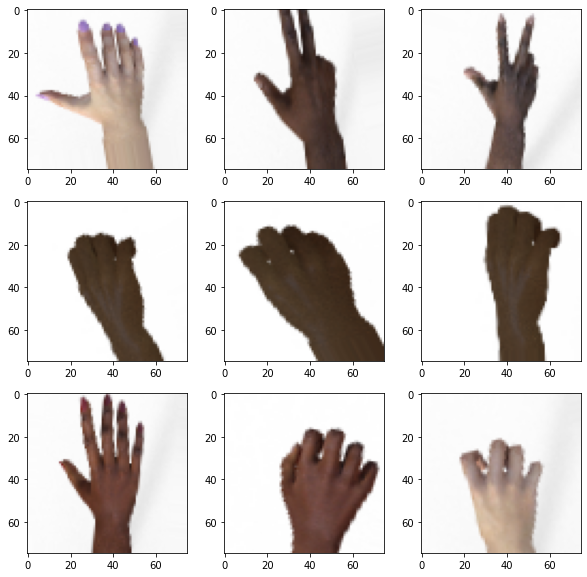

In [11]:
plt.figure(figsize=(10,10))
# generate samples and plot
train_generator.reset()
batch = train_generator.next()
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(batch[0][i])

train_generator.reset()
# show the figure
plt.show()

In [57]:
def model_output_for_TL (pre_trained_model, last_output):
    x = Flatten()(last_output)
    
    # Dense hidden layer
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    # Output neuron.
    x = Dense(3, activation='softmax')(x)
    
    model = Model(pre_trained_model.input, x)
    return model

In [54]:
pre_trained_model = InceptionV3(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
      layer.trainable = False

In [58]:
last_layer = pre_trained_model.get_layer('mixed5')
last_output = last_layer.output
model_TL = model_output_for_TL(pre_trained_model, last_output)

In [60]:
model_TL.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_TL = model_TL.fit(
      train_generator,
      steps_per_epoch=10,  
      epochs=20,
      verbose=1,
      validation_data = validation_generator)

2021-09-15 15:52:11.569621: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-15 15:52:11.574876: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2394460000 Hz


Epoch 1/20
10/10 [==============================] - 27s 2s/step - loss: 5.3159 - accuracy: 0.5296 - val_loss: 0.6533 - val_accuracy: 0.7910
Epoch 2/20
10/10 [==============================] - 20s 2s/step - loss: 0.6735 - accuracy: 0.7775 - val_loss: 0.6472 - val_accuracy: 0.7804
Epoch 3/20
10/10 [==============================] - 22s 2s/step - loss: 0.3216 - accuracy: 0.8833 - val_loss: 0.4476 - val_accuracy: 0.8360
Epoch 4/20
10/10 [==============================] - 22s 2s/step - loss: 0.1453 - accuracy: 0.9404 - val_loss: 0.6210 - val_accuracy: 0.8175
Epoch 5/20
10/10 [==============================] - 21s 2s/step - loss: 0.1036 - accuracy: 0.9611 - val_loss: 0.1421 - val_accuracy: 0.9497
Epoch 6/20
10/10 [==============================] - 20s 2s/step - loss: 0.0669 - accuracy: 0.9767 - val_loss: 0.1756 - val_accuracy: 0.9312
Epoch 7/20
10/10 [==============================] - 21s 2s/step - loss: 0.0361 - accuracy: 0.9865 - val_loss: 0.0611 - val_accuracy: 0.9709
Epoch 8/20
10/10 [==

In [63]:
tf.keras.models.save_model(model_TL,'my_model.hdf5')